In [35]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TactileMaterialDataset(Dataset):
    def __init__(self, file_path, material = None):

        with h5py.File(file_path, 'r') as dataset:
            raw_samples = dataset['samples'][:] / 154.  # Normalize
            materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
        
        if material is not None:
            self.samples = raw_samples[material, :, :, :, :].reshape(1, 100, 16, 1000).reshape(-1, 1000)
            materials = np.array([1])

        else:
            self.samples = raw_samples.reshape(36, 100, 16, 1000).reshape(-1, 1000)

        # Apply FFT along the last axis and separate real & imaginary parts
        fft_transformed = np.fft.rfft(self.samples, axis=1)
        self.samples = np.stack((fft_transformed.real, fft_transformed.imag), axis=0) 
        self.samples = self.samples.reshape(-1, 1002)

        self.samples = torch.tensor(self.samples) 
        self.labels = torch.tensor(np.repeat(range(len(materials)), 100*16)) 
            
        # np.fft.fft
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [34]:
with h5py.File("data/raw/tactmat.h5", 'r') as dataset:
    raw_samples = dataset['samples'][:] / 154.  # Normalize
    materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
    material = 0
    samples = raw_samples.reshape(36, 100, 16, 1000).reshape(-1, 1000)
    
    fft_transformed = np.fft.fft(samples, axis=1)
    rfft_transformed = np.fft.rfft(samples, axis=1)  # Shape: (batch, 501)

    samples = np.stack((rfft_transformed.real, rfft_transformed.imag), axis=0) 
    samples =samples.reshape(-1, 1002)



    print(raw_samples.shape)
    print(samples.shape)
    print(fft_transformed.shape)
    print(rfft_transformed.shape)
    print(rfft_transformed.real.shape)

(36, 100, 1000, 4, 4)
(57600, 1002)
(57600, 1000)
(57600, 501)
(57600, 501)


In [36]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

BATCHSIZE = 16
N_DIM = 1002

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), 
                         nn.ReLU(),
                         nn.Linear(512,  dims_out)
                         )


# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM).to(device)
for k in range(4):
    # add split step and swap step after each coupling block
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

/home/lukas.klostermair/FrEIA/FrEIA/modules/all_in_one_block.py:119: UserWarning: Soft permutation will take a very long time to initialize with 1002 feature channels. Consider using hard permutation instead.
  warnings.warn(("Soft permutation will take a very long time to initialize "


In [40]:
class ClassConditionalGMM(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super(ClassConditionalGMM, self).__init__()
        self.mu = nn.Parameter(torch.zeros(n_classes, latent_dim))
        self.logvar = nn.Parameter(torch.full((n_classes, latent_dim), -1.0))

    def forward(self, z):
        # Compute log-probabilities for each class
        z_expanded = z.unsqueeze(1)
        mu = self.mu.unsqueeze(0)
        logvar = self.logvar.unsqueeze(0)
        log_p = -0.5 * (logvar + (z_expanded - mu)**2 / logvar.exp())
        return log_p.sum(dim=-1)


# New loss

import torch.nn.functional as F

#adaptation of existing loss with log-sum-exp
def information_bottleneck_loss(x, y, model, gmm, beta=1.0):

    # Pass through INN
    z, log_detJ = model(x)  # z: [batch_size, latent_dim]
    z_noisy = z + 0.01 * torch.randn_like(z)
    # Compute squared distances to GMM cluster means
    v = z_noisy.unsqueeze(1) - gmm.mu.unsqueeze(0)
    v2 = v.pow(2).sum(dim=2)

    # Ensure correct shape for GMM variances
    logvar_expanded = gmm.logvar.exp().sum(dim=1, keepdim=True).T

    # Compute generative loss using log-sum-exp
    log_pz = -0.5 * torch.logsumexp(v2 - 2 * logvar_expanded, dim=1)
    L_gen = -(log_pz + log_detJ).mean()
    L_gen = np.symlog(L_gen, 1e-3)

    # Compute classification loss
    w = gmm.logvar.exp().sum(dim=1, keepdim=True).T
    logits = -0.5 * v2 + w

    L_cls = F.cross_entropy(logits, y)
    return L_gen + beta * L_cls

# adaptive beta to enforce classification loss in later epochs
def adaptive_beta(epoch, total_epochs, min_beta=1.0, max_beta=10.0):

    return min_beta + (max_beta - min_beta) * (epoch / total_epochs)







In [41]:
gmm = ClassConditionalGMM(n_classes=36, latent_dim=N_DIM).to(device)
with torch.no_grad():
    gmm.logvar.copy_(torch.full_like(gmm.logvar, -3.0)) # adjust variance to form distinctive clusters

optimizer = torch.optim.Adam(list(inn.parameters()) + list(gmm.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [42]:
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch


best_val_loss = float('inf')
patience = 5
counter = 0

# Define dataset
train_dataset = TactileMaterialDataset("data/raw/tactmat.h5")

# Split into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define DataLoaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

inn.to(device)
gmm.to(device)

# Training loop
for i in range(30):
    beta = adaptive_beta(i, 30)
    inn.train()
    train_loss = 0
    for data, c_batch in tqdm(train_loader):
        optimizer.zero_grad()

        x = torch.tensor(data.float()).to(device)
        c_batch = c_batch.to(device)
    
        z, log_jac_det = inn(x)
        
        loss = information_bottleneck_loss(x, c_batch, inn, gmm, beta)
        train_loss += loss.item()
    
        loss.backward()
        optimizer.step()
    
    # Validation loop
    inn.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, c_batch in val_loader:
            x_batch = torch.tensor(x_batch.float()).to(device)
            c_batch = c_batch.to(device)
            
            loss = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
            val_loss += loss.item()
            
            z, _ = inn(x_batch)
            preds = gmm(z).argmax(dim=1)
            correct += (preds == c_batch).sum().item()
            total += c_batch.size(0)
    
    val_acc = correct / total
    print(f"Epoch {i+1}: Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    #Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break



: 

In [21]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE, N_DIM)
samples, _ = inn(z,1, rev=True)
samples = samples.detach().numpy()

In [21]:
with h5py.File("tactmat.h5", 'r') as dataset:
    raw_samples = dataset['samples'][:] / 154.  # Normalize
    materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
    
    samples_2 = raw_samples[2, :, :, :, :].reshape(1, 100, 16, 1000)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


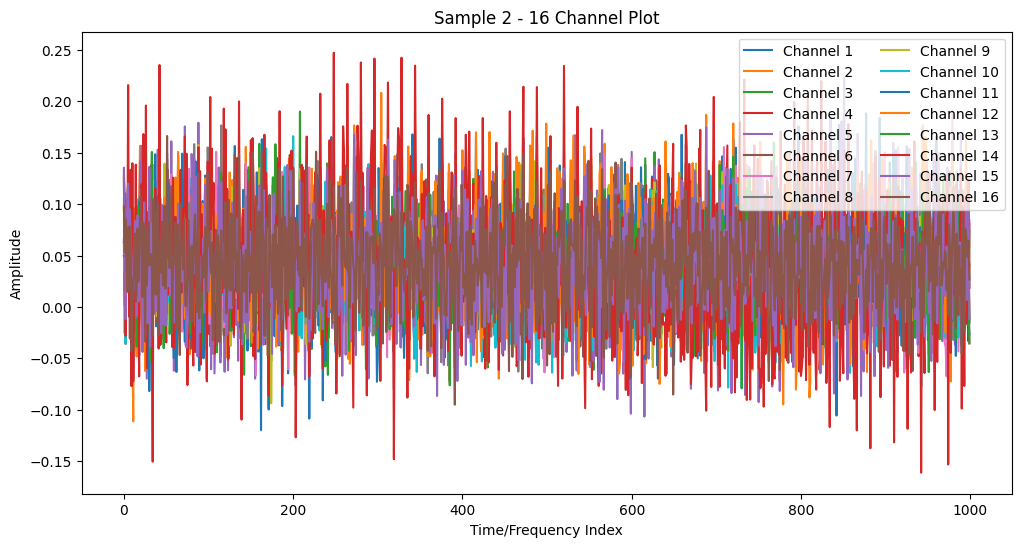

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i in range(16):
    fft_transformed = samples[i, :1000] + 1j * samples[i, 1000:]

    # Compute the inverse FFT
    ifft_transformed = np.fft.ifft(fft_transformed)

    # If the original signal was real-valued, extract the real part
    recovered_signal = np.real(ifft_transformed)
    
    plt.plot(recovered_signal, label=f'Channel {i+1}')

plt.title(f'Sample 2 - 16 Channel Plot')
plt.xlabel('Time/Frequency Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=2)  # Adjust legend position
plt.show()


In [44]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)

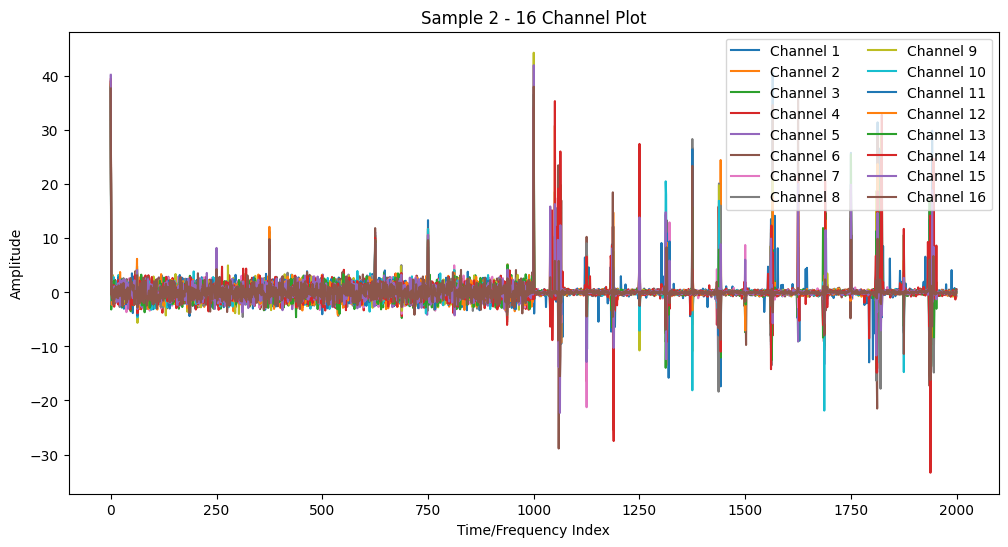

In [60]:

for i in range(16):
    plt.plot(samples[i, :], label=f'Channel {i+1}')

plt.title(f'Sample 2 - 16 Channel Plot')
plt.xlabel('Time/Frequency Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=2)  # Adjust legend position
plt.show()